# Value at Risk (VaR): Quantifying Potential Losses

**Time:** 18 minutes

**Prerequisites:** 04_returns_and_performance.ipynb, 06_maximum_drawdown.ipynb

---

Risk managers need to answer: **"What's the most I could lose?"** Value at Risk (VaR) provides a statistical answer: "With X% confidence, you won't lose more than $Y over the next N days."

## What is Value at Risk?

**Value at Risk (VaR)** is the maximum expected loss over a specific time period at a given confidence level.

**VaR Statement:**

> "With 95% confidence, we will not lose more than $X over the next 1 day."

**Three Components:**

1. **Confidence Level** (e.g., 95%, 99%): How sure are we?
2. **Time Horizon** (e.g., 1 day, 10 days): Over what period?
3. **Loss Amount** (e.g., $10,000): The VaR value

**Mental Model: The Weather Forecast**

Think of VaR like a weather forecast: "There's a 95% chance it won't rain more than 2 inches tomorrow." But 5% of the time, it could rain more. VaR tells you the threshold, not the worst case.

## Three Methods to Calculate VaR

### 1. Historical Method
Use actual historical returns to find the percentile.

### 2. Parametric (Variance-Covariance) Method
Assume returns are normally distributed.

$$\text{VaR} = \mu - z \times \sigma$$

Where:
- $\mu$ = Mean return
- $z$ = Z-score for confidence level (1.65 for 95%, 2.33 for 99%)
- $\sigma$ = Standard deviation

### 3. Monte Carlo Simulation
Simulate thousands of scenarios and find the percentile.

In [ ]:
# Install required packages
!pip install -q yfinance pandas numpy matplotlib scipy

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def get_returns(ticker, period="2y"):
    """Get daily returns for a ticker."""
    stock = yf.Ticker(ticker)
    hist = stock.history(period=period)
    returns = hist['Close'].pct_change().dropna()
    return returns

def calculate_historical_var(returns, confidence_level=0.95, portfolio_value=100000):
    """Calculate VaR using the Historical Method.

    Args:
        returns: Series of daily returns
        confidence_level: Confidence level (e.g., 0.95 for 95%)
        portfolio_value: Current portfolio value in dollars

    Returns:
        Dictionary with VaR metrics
    """
    # The VaR percentile is (1 - confidence_level)
    var_percentile = 1 - confidence_level

    # Find the return at the VaR percentile
    var_return = np.percentile(returns, var_percentile * 100)

    # Convert to dollar amount
    var_dollar = portfolio_value * abs(var_return)

    return {
        'method': 'Historical',
        'confidence_level': confidence_level,
        'var_return_pct': var_return * 100,
        'var_dollar': var_dollar,
        'portfolio_value': portfolio_value
    }

# Example: Calculate Historical VaR for a stock
ticker = "AAPL"
returns = get_returns(ticker)
portfolio_value = 100000

var_95 = calculate_historical_var(returns, 0.95, portfolio_value)
var_99 = calculate_historical_var(returns, 0.99, portfolio_value)

print(f"Historical VaR Analysis: {ticker}")
print(f"Portfolio Value: ${portfolio_value:,}")
print("=" * 55)
print(f"\n95% VaR (1-day):")
print(f"  Return threshold: {var_95['var_return_pct']:.2f}%")
print(f"  Dollar VaR:       ${var_95['var_dollar']:,.0f}")
print(f"  Interpretation:   With 95% confidence, you won't lose more")
print(f"                    than ${var_95['var_dollar']:,.0f} in a single day.")

print(f"\n99% VaR (1-day):")
print(f"  Return threshold: {var_99['var_return_pct']:.2f}%")
print(f"  Dollar VaR:       ${var_99['var_dollar']:,.0f}")
print(f"  Interpretation:   With 99% confidence, you won't lose more")
print(f"                    than ${var_99['var_dollar']:,.0f} in a single day.")

Historical VaR Analysis: AAPL
Portfolio Value: $100,000

95% VaR (1-day):
  Return threshold: -2.71%
  Dollar VaR:       $2,706
  Interpretation:   With 95% confidence, you won't lose more
                    than $2,706 in a single day.

99% VaR (1-day):
  Return threshold: -4.25%
  Dollar VaR:       $4,251
  Interpretation:   With 99% confidence, you won't lose more
                    than $4,251 in a single day.


## Visualizing Historical VaR

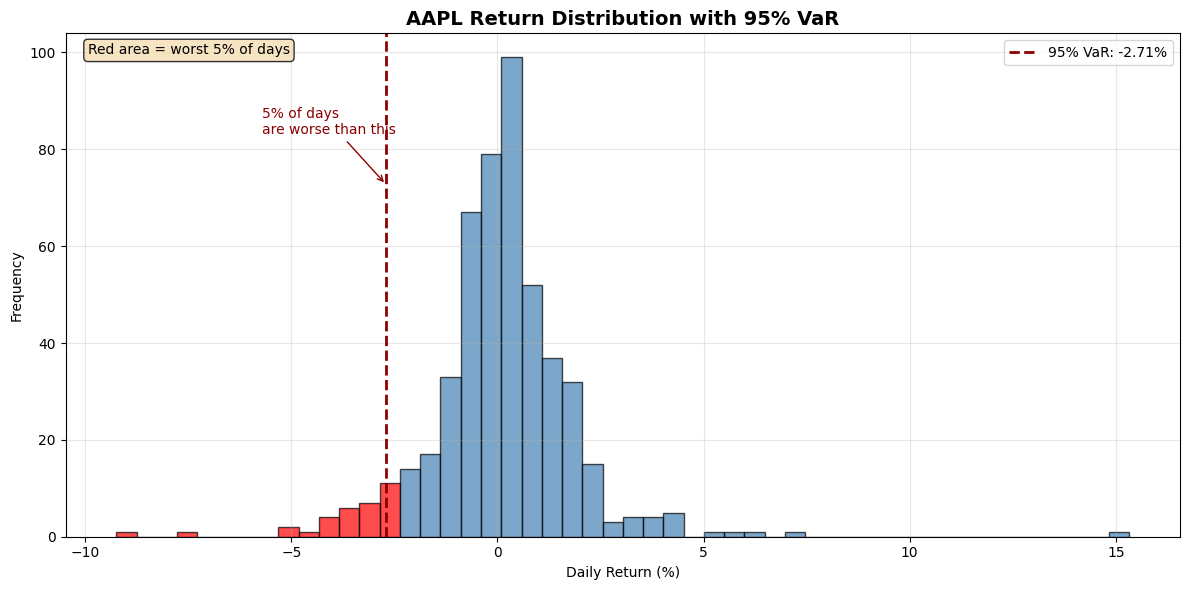

In [2]:
def plot_var_distribution(returns, ticker, confidence_level=0.95):
    """Visualize VaR on return distribution."""
    var_return = np.percentile(returns, (1 - confidence_level) * 100)

    fig, ax = plt.subplots(figsize=(12, 6))

    returns_pct = returns * 100
    var_pct = var_return * 100

    # Histogram
    n, bins, patches = ax.hist(returns_pct, bins=50, alpha=0.7, edgecolor='black')

    # Color the VaR tail red
    for patch, left_edge in zip(patches, bins[:-1]):
        if left_edge < var_pct:
            patch.set_facecolor('red')
        else:
            patch.set_facecolor('steelblue')

    # VaR line
    ax.axvline(var_pct, color='darkred', linestyle='--', linewidth=2,
              label=f'{confidence_level*100:.0f}% VaR: {var_pct:.2f}%')

    # Add annotations
    ax.annotate(f'{(1-confidence_level)*100:.0f}% of days\nare worse than this',
               xy=(var_pct, ax.get_ylim()[1] * 0.7),
               xytext=(var_pct - 3, ax.get_ylim()[1] * 0.8),
               fontsize=10, color='darkred',
               arrowprops=dict(arrowstyle='->', color='darkred'))

    ax.set_xlabel('Daily Return (%)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{ticker} Return Distribution with {confidence_level*100:.0f}% VaR',
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

    # Add text box
    textstr = f'Red area = worst {(1-confidence_level)*100:.0f}% of days'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()

# Visualize
plot_var_distribution(returns, ticker, 0.95)

## Parametric (Variance-Covariance) VaR

Assumes returns follow a normal distribution.

In [3]:
def calculate_parametric_var(returns, confidence_level=0.95, portfolio_value=100000):
    """Calculate VaR using the Parametric (Variance-Covariance) Method.

    Assumes returns are normally distributed.
    """
    # Calculate mean and std of returns
    mu = returns.mean()
    sigma = returns.std()

    # Z-score for confidence level
    z_score = stats.norm.ppf(1 - confidence_level)

    # VaR formula: mu + z * sigma (z is negative for left tail)
    var_return = mu + z_score * sigma

    # Convert to dollar amount
    var_dollar = portfolio_value * abs(var_return)

    return {
        'method': 'Parametric',
        'confidence_level': confidence_level,
        'var_return_pct': var_return * 100,
        'var_dollar': var_dollar,
        'mean_return_pct': mu * 100,
        'std_return_pct': sigma * 100,
        'z_score': z_score
    }

# Calculate Parametric VaR
param_var_95 = calculate_parametric_var(returns, 0.95, portfolio_value)

print(f"Parametric VaR Analysis: {ticker}")
print("=" * 55)
print(f"Mean Daily Return:     {param_var_95['mean_return_pct']:.3f}%")
print(f"Daily Volatility:      {param_var_95['std_return_pct']:.3f}%")
print(f"Z-Score (95%):         {param_var_95['z_score']:.3f}")
print(f"\n95% VaR (1-day):")
print(f"  Return threshold: {param_var_95['var_return_pct']:.2f}%")
print(f"  Dollar VaR:       ${param_var_95['var_dollar']:,.0f}")
print(f"\nFormula: VaR = μ + z × σ")
print(f"         VaR = {param_var_95['mean_return_pct']:.3f}% + ({param_var_95['z_score']:.3f} × {param_var_95['std_return_pct']:.3f}%)")
print(f"         VaR = {param_var_95['var_return_pct']:.3f}%")

Parametric VaR Analysis: AAPL
Mean Daily Return:     0.090%
Daily Volatility:      1.767%
Z-Score (95%):         -1.645

95% VaR (1-day):
  Return threshold: -2.82%
  Dollar VaR:       $2,816

Formula: VaR = μ + z × σ
         VaR = 0.090% + (-1.645 × 1.767%)
         VaR = -2.816%


## Monte Carlo VaR

Simulate many possible scenarios to estimate VaR.

In [4]:
def calculate_monte_carlo_var(returns, confidence_level=0.95, portfolio_value=100000,
                               n_simulations=10000):
    """Calculate VaR using Monte Carlo Simulation.

    Simulates future returns based on historical statistics.
    """
    # Get parameters from historical data
    mu = returns.mean()
    sigma = returns.std()

    # Simulate random returns
    np.random.seed(42)  # For reproducibility
    simulated_returns = np.random.normal(mu, sigma, n_simulations)

    # Find VaR percentile from simulations
    var_return = np.percentile(simulated_returns, (1 - confidence_level) * 100)

    # Convert to dollar amount
    var_dollar = portfolio_value * abs(var_return)

    return {
        'method': 'Monte Carlo',
        'confidence_level': confidence_level,
        'var_return_pct': var_return * 100,
        'var_dollar': var_dollar,
        'n_simulations': n_simulations,
        'simulated_returns': simulated_returns
    }

# Calculate Monte Carlo VaR
mc_var_95 = calculate_monte_carlo_var(returns, 0.95, portfolio_value)

print(f"Monte Carlo VaR Analysis: {ticker}")
print("=" * 55)
print(f"Simulations:        {mc_var_95['n_simulations']:,}")
print(f"\n95% VaR (1-day):")
print(f"  Return threshold: {mc_var_95['var_return_pct']:.2f}%")
print(f"  Dollar VaR:       ${mc_var_95['var_dollar']:,.0f}")

Monte Carlo VaR Analysis: AAPL
Simulations:        10,000

95% VaR (1-day):
  Return threshold: -2.83%
  Dollar VaR:       $2,834


## Comparing All Three Methods

In [5]:
def compare_var_methods(returns, confidence_level=0.95, portfolio_value=100000):
    """Compare all three VaR calculation methods."""
    hist_var = calculate_historical_var(returns, confidence_level, portfolio_value)
    param_var = calculate_parametric_var(returns, confidence_level, portfolio_value)
    mc_var = calculate_monte_carlo_var(returns, confidence_level, portfolio_value)

    return [hist_var, param_var, mc_var]

methods = compare_var_methods(returns, 0.95, portfolio_value)

print(f"VaR Method Comparison: {ticker} at 95% Confidence")
print(f"Portfolio Value: ${portfolio_value:,}")
print("=" * 55)
print(f"{'Method':<15} {'VaR Return':>15} {'VaR Dollar':>15}")
print("-" * 55)

for m in methods:
    print(f"{m['method']:<15} {m['var_return_pct']:>14.2f}% ${m['var_dollar']:>13,.0f}")

# Average
avg_var = np.mean([m['var_dollar'] for m in methods])
print("-" * 55)
print(f"{'Average':<15} {'':<15} ${avg_var:>13,.0f}")

VaR Method Comparison: AAPL at 95% Confidence
Portfolio Value: $100,000
Method               VaR Return      VaR Dollar
-------------------------------------------------------
Historical               -2.71% $        2,706
Parametric               -2.82% $        2,816
Monte Carlo              -2.83% $        2,834
-------------------------------------------------------
Average                         $        2,785


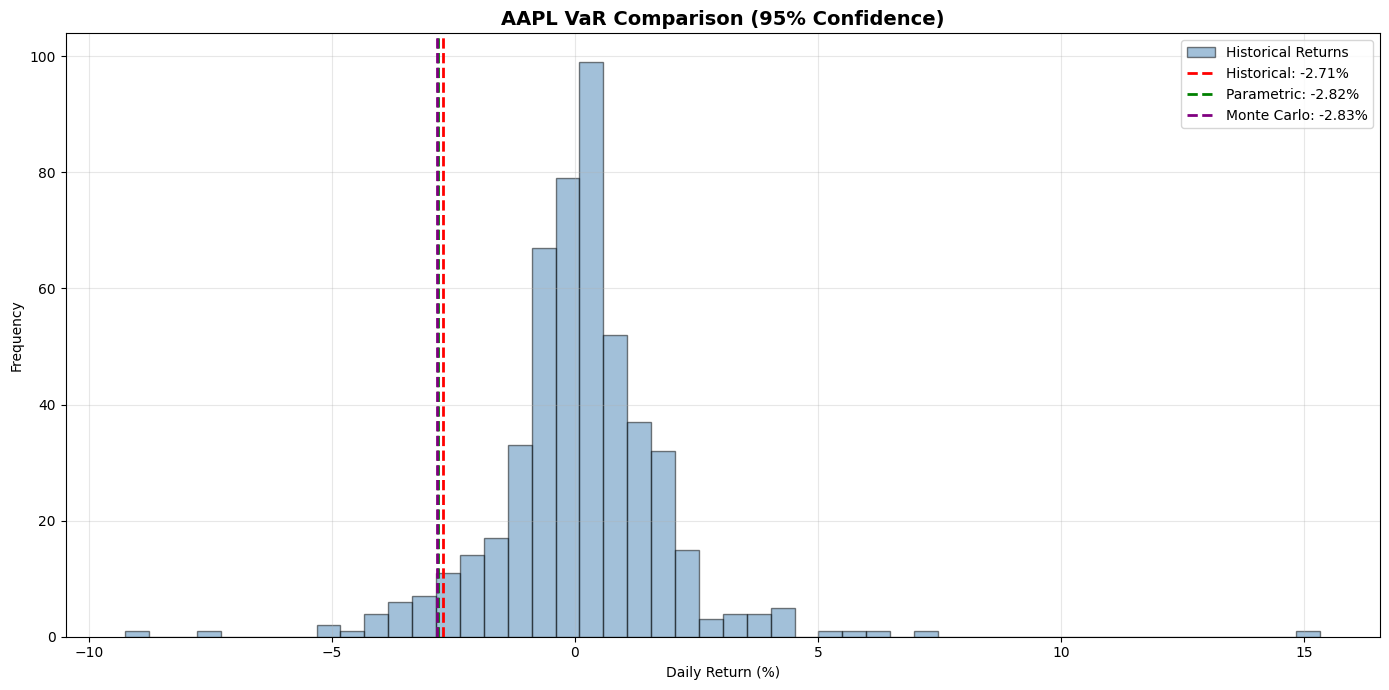

In [6]:
def plot_var_comparison(returns, methods, ticker):
    """Visualize VaR from different methods on the same distribution."""
    fig, ax = plt.subplots(figsize=(14, 7))

    returns_pct = returns * 100

    # Histogram
    ax.hist(returns_pct, bins=50, alpha=0.5, color='steelblue',
            edgecolor='black', label='Historical Returns')

    # VaR lines for each method
    colors = ['red', 'green', 'purple']
    for m, color in zip(methods, colors):
        ax.axvline(m['var_return_pct'], color=color, linestyle='--', linewidth=2,
                  label=f"{m['method']}: {m['var_return_pct']:.2f}%")

    ax.set_xlabel('Daily Return (%)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{ticker} VaR Comparison (95% Confidence)', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_var_comparison(returns, methods, ticker)

## Multi-Day VaR: Scaling Over Time

To scale VaR to multiple days, we use the **square root of time** rule:

$$\text{VaR}_{n-day} = \text{VaR}_{1-day} \times \sqrt{n}$$

**Example:** If 1-day VaR is $5,000, then 10-day VaR ≈ $5,000 × √10 ≈ $15,811

In [8]:
def calculate_multiday_var(one_day_var, days):
    """Scale 1-day VaR to multiple days.

    Uses the square root of time rule.
    """
    return one_day_var * np.sqrt(days)

# Calculate for different time horizons
one_day_var = var_95['var_dollar']

print(f"Multi-Day VaR (95% Confidence)")
print(f"Base: 1-day VaR = ${one_day_var:,.0f}")
print("=" * 45)
print(f"{'Time Horizon':<20} {'VaR ($)':>15} {'Scaling Factor':>12}")
print("-" * 45)

for days in [1, 5, 10, 21, 63, 252]:
    labels = {1: '1 day', 5: '1 week', 10: '2 weeks',
              21: '1 month', 63: '1 quarter', 252: '1 year'}
    multiday_var = calculate_multiday_var(one_day_var, days)
    print(f"{labels[days]:<20} ${multiday_var:>13,.0f} √{days:>3} = {np.sqrt(days):.2f}")

print("\n⚠️  Note: Square root rule assumes returns are independent.")
print("    In reality, returns can be autocorrelated, especially in crises.")

Multi-Day VaR (95% Confidence)
Base: 1-day VaR = $2,706
Time Horizon                 VaR ($) Scaling Factor
---------------------------------------------
1 day                $        2,706 √  1 = 1.00
1 week               $        6,050 √  5 = 2.24
2 weeks              $        8,556 √ 10 = 3.16
1 month              $       12,399 √ 21 = 4.58
1 quarter            $       21,476 √ 63 = 7.94
1 year               $       42,951 √252 = 15.87

⚠️  Note: Square root rule assumes returns are independent.
    In reality, returns can be autocorrelated, especially in crises.


## Portfolio VaR

For a portfolio, we need to account for correlations between assets.

In [9]:
def calculate_portfolio_var(holdings, period="2y", confidence_level=0.95, total_value=100000):
    """Calculate VaR for a weighted portfolio.

    Args:
        holdings: Dict of {ticker: weight} where weights sum to 1.0
        period: Historical period for data
        confidence_level: VaR confidence level
        total_value: Total portfolio value
    """
    # Get returns for all holdings
    returns_dict = {}
    for ticker in holdings.keys():
        stock = yf.Ticker(ticker)
        hist = stock.history(period=period)
        returns_dict[ticker] = hist['Close'].pct_change().dropna()

    # Combine into DataFrame
    returns_df = pd.DataFrame(returns_dict).dropna()

    # Calculate portfolio returns
    portfolio_returns = pd.Series(0.0, index=returns_df.index)
    for ticker, weight in holdings.items():
        portfolio_returns += returns_df[ticker] * weight

    # Calculate VaR using all three methods
    hist_var = calculate_historical_var(portfolio_returns, confidence_level, total_value)
    param_var = calculate_parametric_var(portfolio_returns, confidence_level, total_value)
    mc_var = calculate_monte_carlo_var(portfolio_returns, confidence_level, total_value)

    # Individual VaRs for comparison
    individual_vars = {}
    for ticker, weight in holdings.items():
        position_value = total_value * weight
        ind_var = calculate_historical_var(returns_df[ticker], confidence_level, position_value)
        individual_vars[ticker] = ind_var['var_dollar']

    return {
        'portfolio_var': hist_var,
        'parametric_var': param_var,
        'monte_carlo_var': mc_var,
        'individual_vars': individual_vars,
        'undiversified_var': sum(individual_vars.values()),
        'diversification_benefit': sum(individual_vars.values()) - hist_var['var_dollar'],
        'portfolio_returns': portfolio_returns
    }

# Example portfolio
portfolio = {
    'AAPL': 0.25,
    'MSFT': 0.25,
    'JPM': 0.25,
    'XOM': 0.25
}

port_var = calculate_portfolio_var(portfolio, total_value=100000)

print("Portfolio VaR Analysis (95% Confidence)")
print("Total Portfolio Value: $100,000")
print("=" * 60)

print("\nIndividual Position VaRs:")
for ticker, var in port_var['individual_vars'].items():
    print(f"  {ticker}: ${var:,.0f}")

print(f"\nUndiversified VaR (sum): ${port_var['undiversified_var']:,.0f}")
print(f"Diversified Portfolio VaR: ${port_var['portfolio_var']['var_dollar']:,.0f}")
print(f"\nDiversification Benefit: ${port_var['diversification_benefit']:,.0f}")
print(f"                         ({port_var['diversification_benefit']/port_var['undiversified_var']*100:.1f}% reduction)")

Portfolio VaR Analysis (95% Confidence)
Total Portfolio Value: $100,000

Individual Position VaRs:
  AAPL: $676
  MSFT: $586
  JPM: $536
  XOM: $539

Undiversified VaR (sum): $2,336
Diversified Portfolio VaR: $1,420

Diversification Benefit: $916
                         (39.2% reduction)


## Conditional VaR (CVaR / Expected Shortfall)

VaR tells you the threshold, but what if you exceed it? **CVaR** (Conditional VaR) or **Expected Shortfall** answers: "If we do exceed VaR, what's the average loss?"

$$\text{CVaR} = E[\text{Loss} | \text{Loss} > \text{VaR}]$$

In [ ]:
def calculate_cvar(returns, confidence_level=0.95, portfolio_value=100000):
    """Calculate Conditional VaR (Expected Shortfall).

    CVaR is the average loss when losses exceed VaR.
    """
    var_percentile = 1 - confidence_level
    var_return = np.percentile(returns, var_percentile * 100)

    # Get all returns worse than VaR
    tail_returns = returns[returns <= var_return]

    # Average of tail returns
    cvar_return = tail_returns.mean()

    # Convert to dollars
    var_dollar = portfolio_value * abs(var_return)
    cvar_dollar = portfolio_value * abs(cvar_return)

    return {
        'var_return_pct': var_return * 100,
        'var_dollar': var_dollar,
        'cvar_return_pct': cvar_return * 100,
        'cvar_dollar': cvar_dollar,
        'n_tail_observations': len(tail_returns)
    }

# Calculate CVaR
cvar_result = calculate_cvar(returns, 0.95, portfolio_value)

print(f"VaR vs CVaR Comparison: {ticker}")
print("=" * 55)
print(f"\n95% VaR:")
print(f"  Return threshold: {cvar_result['var_return_pct']:.2f}%")
print(f"  Dollar amount:    ${cvar_result['var_dollar']:,.0f}")
print(f"  Meaning:          'We won't lose more than this 95% of the time'")

print(f"\n95% CVaR (Expected Shortfall):")
print(f"  Average tail loss: {cvar_result['cvar_return_pct']:.2f}%")
print(f"  Dollar amount:     ${cvar_result['cvar_dollar']:,.0f}")
print(f"  Tail observations: {cvar_result['n_tail_observations']}")
print(f"  Meaning:           'When we DO exceed VaR, we lose this much on average'")

print(f"\nKey Insight: CVaR (${cvar_result['cvar_dollar']:,.0f}) is {cvar_result['cvar_dollar']/cvar_result['var_dollar']*100-100:.0f}% worse than VaR")

## VaR Limitations

**What VaR Doesn't Tell You:**

1. **How bad can it get?** VaR is a threshold, not a worst case
2. **Tail risk:** The 5% (or 1%) worst days can be MUCH worse than VaR
3. **Assumes normal conditions:** VaR often fails during market crises
4. **Model risk:** Different methods give different answers

**Famous VaR Failures:**
- 2008 Financial Crisis: Banks' VaR models dramatically underestimated risk
- LTCM 1998: Their models didn't anticipate Russian default contagion

## Key Takeaways

### Formulas You've Learned:

1. **Historical VaR** = Percentile of actual returns

2. **Parametric VaR** = μ + z × σ

3. **Multi-Day VaR** = 1-day VaR × √n

4. **CVaR** = Average loss when exceeding VaR

### Key Concepts:

- **VaR has three components:** Confidence level, time horizon, loss amount
- **Three methods:** Historical, Parametric, Monte Carlo
- **Diversification reduces VaR:** Portfolio VaR < sum of individual VaRs
- **CVaR complements VaR:** Tells you about tail severity

### Why This Matters for AI Agents:

When we build AI agents, they'll need to:
- Calculate and monitor VaR daily
- Alert when VaR exceeds risk limits
- Compare VaR across different portfolios
- Use CVaR for more conservative risk management

**Next Notebook:** We'll learn about portfolio rebalancing - bringing weights back to targets.